<a href="https://colab.research.google.com/github/fmdsocial/pdj/blob/main/PDJ_18_04_2024ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDJ - Predição de mortalidade entre brasileiros com 50 anos ou mais


Criado por Felipe Delpino

## **Etapas de Análise**
**1. Instalação de pacotes adicionais**

**2. Importação de bibliotecas e pacotes**

**3. Obtendo o conjunto de dados**

**4. Preparação do conjunto de dados (pré-processamento)**

**5. Função auxiliar RunModel**

**6. Execução dos algoritmos de machine learning**

**7. Não quero fazer nessa estrutrutura automatizada, como proceder?**

**8. Seleção de variáveis com BORUTA**

**9. Catboost com BORUTA**

**10. Valores de Shapley**

**11. Salvando e carregando o modelo**



---

**1. Instalação de pacotes adicionais**

In [ ]:
# ver descrição dos pacotes na seção de importação
!pip install dfply
!pip install scikit-plot
!pip install graphviz
!pip install dtreeviz

**2. Importação de bibliotecas e pacotes**

In [ ]:
import pandas as pd # para processamento de bancos de dados
import numpy as np # para processamento numérico de bancos de dados
import matplotlib # para geração de gráficos
import matplotlib.pyplot as plt # configurações adicionais para os gráficos a serem gerados

# informamos ao Python que estamos usando um notebook e que os gráficos devem ser exibidos nele
%matplotlib inline

import seaborn as sns #alternativa para a matplotlib para geração de gráficos

# SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from dfply import *  # para importar os comandos da biblioteca dfply

import scikitplot as skplt

from dtreeviz.trees import *

import warnings # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")

# configurações adicionais de figuras
plt.rcParams["figure.figsize"] = [10, 5]
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

np.random.seed(42)  # semente de aleatoriedade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Obtendo o conjunto de dados**

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/PÓS-DOUTORADO UFPel/Artigo original PDJ/ELSI/elsi_12_12.xlsx')

3.1 Verificando o conjunto de dados

In [ ]:
dataset.shape # utilizamos o comando .shape para a verificação do número de linhas e número de colunas (linhas, colunas). Aqui já sabemos se há algum problema de importação nos dados

(9412, 60)

In [ ]:
# Teste com idosos com 70 ou mais
dataset = dataset[dataset['idade'] >= 70]


In [ ]:
# o comando .head é importante para verificarmos as linhas inicias de um conjunto de dados
# por padrão, ele apresenta as 5 linhas inicias. Porém, podemos alterar este valor indicando o n° de linhas dentro dos parênteses, como dataset.head(10)
# uma alternativa ao .head é o .tail, que apresenta os últimos valores da tabela de dados
dataset.head(5)

,idade,sexo,i1,obito,conjug,esc,renda3,diab,has,inf,...,inst,feze,mem,satvida,satvidao,medn,plano,servsau,intern,urg
0,81,Masculino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,mais ricos,nao,sim,nao,...,nao,nao,boa,6.00,6.00,6.00,sim,nao,sim,nao
2,89,Masculino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,mais pobres,nao,sim,sim,...,nao,nao,boa,NaN,NaN,4.00,sim,nao,nao,nao
3,73,Masculino,nao,nao,casado,menos de 8 anos,media,sim,nao,nao,...,nao,nao,boa,8.00,6.00,2.00,nao,nao,nao,nao
13,74,Masculino,nao,nao,casado,menos de 8 anos,mais pobres,sim,nao,nao,...,nao,nao,regular,5.00,5.00,2.00,nao,nao,nao,nao
14,72,Feminino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,media,nao,nao,nao,...,nao,nao,boa,10.00,3.00,0.00,nao,nao,sim,nao


In [ ]:
dataset.info() # utilizamos o info para verificar as caracterísitcas iniciais as variáveis, como nome das colunas, presença de valores não preenchidos e codificação

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 0 to 9409
Data columns (total 60 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     2557 non-null   int64  
 1   sexo      2557 non-null   object 
 2   i1        2557 non-null   object 
 3   obito     2557 non-null   object 
 4   conjug    2557 non-null   object 
 5   esc       2524 non-null   object 
 6   renda3    2557 non-null   object 
 7   diab      2540 non-null   object 
 8   has       2553 non-null   object 
 9   inf       2548 non-null   object 
 10  cancer    2549 non-null   object 
 11  autsa     2552 non-null   object 
 12  imc       2340 non-null   float64
 13  fumo      2555 non-null   object 
 14  sono      2551 non-null   object 
 15  cam       2506 non-null   object 
 16  afm10     2530 non-null   object 
 17  afv10     2533 non-null   object 
 18  temps     2379 non-null   float64
 19  tempf     2318 non-null   float64
 20  leg       2542 non-null   object 
 

Neste caso, nosso conjunto de dados não possui valores sem preenchimento. No entanto, é importante verificar se não há missing codificado, como "999", "000", "não disponível", "não preenchido", etc.


**4. Preparação do conjunto de dados (pré-processamento)**






4.1 Filtrando o conjunto de dados

Para os modelos preditivos a serem desenvolvidos, iremos considerar individuos com idade superior a 55 anos.
Removeremos também as variáveis "patientID", "age" e "treat"

In [ ]:
#Checando missings. Nesse caso, foram atribuídas médias às variáveis numéricas com missings
missing_values_count = dataset.isnull().sum()
print(missing_values_count)

idade         0
sexo          0
i1            0
obito         0
conjug        0
esc          33
renda3        0
diab         17
has           4
inf           9
cancer        8
autsa         5
imc         217
fumo          2
sono          6
cam          51
afm10        27
afv10        24
temps       178
tempf       239
leg          15
frut         30
carne        27
peixe        12
glauc       278
retin       269
macula      292
cat         259
queda         3
colt         30
ang          23
ins          15
avc           4
asma          3
enfs          5
art          23
ost          42
col          12
dep          12
insf         12
park         11
alzh          8
ppeso       134
coisas       91
rotin        81
remsono       5
dentsau      15
ndente       70
acam          0
cad           0
inst          1
feze          4
mem         244
satvida     530
satvidao    530
medn         12
plano         4
servsau      14
intern       11
urg           9
dtype: int64


In [ ]:
dataset['imc'] = dataset['imc'].fillna(dataset['imc'].mean())

In [ ]:
dataset['temps'] = dataset['temps'].fillna(dataset['temps'].mean())

In [ ]:
dataset['tempf'] = dataset['tempf'].fillna(dataset['tempf'].mean())

In [ ]:
dataset['satvida'] = dataset['satvida'].fillna(dataset['satvida'].mean())

In [ ]:
dataset['satvidao'] = dataset['satvidao'].fillna(dataset['satvidao'].mean())

In [ ]:
dataset['medn'] = dataset['medn'].fillna(dataset['medn'].mean())

In [ ]:
dataset.head(5)

,idade,sexo,i1,obito,conjug,esc,renda3,diab,has,inf,...,inst,feze,mem,satvida,satvidao,medn,plano,servsau,intern,urg
0,81,Masculino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,mais ricos,nao,sim,nao,...,nao,nao,boa,6.00,6.00,6.00,sim,nao,sim,nao
2,89,Masculino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,mais pobres,nao,sim,sim,...,nao,nao,boa,NaN,NaN,4.00,sim,nao,nao,nao
3,73,Masculino,nao,nao,casado,menos de 8 anos,media,sim,nao,nao,...,nao,nao,boa,8.00,6.00,2.00,nao,nao,nao,nao
13,74,Masculino,nao,nao,casado,menos de 8 anos,mais pobres,sim,nao,nao,...,nao,nao,regular,5.00,5.00,2.00,nao,nao,nao,nao
14,72,Feminino,nao,nao,solteiro/divorciado ou separado/viuvo,menos de 8 anos,media,nao,nao,nao,...,nao,nao,boa,10.00,3.00,0.00,nao,nao,sim,nao


4.2 Para as variáveis categóricas iremos criar dummies

In [ ]:
# aqui foi inserido o comando get_dummies para a realização do one hot encoding para as variáveis categórias
# obs: as variáveis dicotômicas não precisam passar pelo one hot encoding. Pode somente aplicar o label encoding, substintuindo os valores por 0 e 1

dataset = pd.get_dummies(dataset, columns=['esc',
'renda3',
'leg',
'frut',
'carne',
'peixe',
'cam',
'afm10',
'afv10',
'remsono',
'coisas',
'rotin',
'dentsau',
'ndente',
'mem'])

In [ ]:
dataset.head(10).T # utilizei o comando .T para transpor a visualização

,0,2,3,13,14,17,19,20,21,26
idade,81,89,73,74,72,70,78,79,77,73
sexo,Masculino,Masculino,Masculino,Masculino,Feminino,Masculino,Feminino,Feminino,Masculino,Feminino
i1,nao,nao,nao,nao,nao,nao,nao,nao,nao,nao
obito,nao,nao,nao,nao,nao,nao,nao,nao,nao,nao
conjug,solteiro/divorciado ou separado/viuvo,solteiro/divorciado ou separado/viuvo,casado,casado,solteiro/divorciado ou separado/viuvo,solteiro/divorciado ou separado/viuvo,solteiro/divorciado ou separado/viuvo,casado,solteiro/divorciado ou separado/viuvo,solteiro/divorciado ou separado/viuvo
...,...,...,...,...,...,...,...,...,...,...
mem_boa,True,True,True,False,True,False,False,False,True,True
mem_excelente,False,False,False,False,False,False,False,False,False,False
mem_muito boa,False,False,False,False,False,False,True,False,False,False
mem_regular,False,False,False,True,False,True,False,True,False,False


In [ ]:
dataset[['sexo', 'i1', 'obito', 'conjug', 'diab', 'has', 'inf', 'cancer', 'autsa', 'fumo', 'sono', 'glauc', 'retin', 'macula', 'cat', 'queda', 'colt', 'ang', 'ins', 'avc', 'asma', 'enfs', 'art', 'ost', 'col', 'dep', 'insf', 'park', 'alzh', 'ppeso', 'acam', 'cad', 'inst', 'feze', 'plano', 'servsau', 'intern', 'urg']] = dataset[['sexo', 'i1', 'obito', 'conjug', 'diab', 'has', 'inf', 'cancer', 'autsa', 'fumo', 'sono', 'glauc', 'retin', 'macula', 'cat', 'queda', 'colt', 'ang', 'ins', 'avc', 'asma', 'enfs', 'art', 'ost', 'col', 'dep', 'insf', 'park', 'alzh', 'ppeso', 'acam', 'cad', 'inst', 'feze', 'plano', 'servsau', 'intern', 'urg']].apply(preprocessing.LabelEncoder().fit_transform)
# o label enconder utiliza por padrão a ordem alfabética. Dessa forma, como os dados estavam com categorias "N" e "Y", "N" assume o valor 0 e "Y" o valor 1
# para o sexo: F -> 0,  M -> 1
# caso este não seja o cenário desejado, é possível invertar a ordem pelo inverse_transform

In [ ]:
dataset.head(20).T

,0,2,3,13,14,17,19,20,21,26,28,29,31,33,35,42,48,54,57,58
idade,81,89,73,74,72,70,78,79,77,73,85,79,75,74,80,71,76,73,77,77
sexo,1,1,1,1,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0
i1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
obito,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
conjug,1,1,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mem_boa,True,True,True,False,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False
mem_excelente,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
mem_muito boa,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
mem_regular,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,True,True,True,True,False


4.3 Obtendo os conjuntos de treino e teste

In [ ]:
variaveis_preditoras = dataset.iloc[:, dataset.columns != 'obito'] # separamos as nossas variáveis preditoras do nosso desfecho/target ==> conjunto X
classe = dataset.iloc[:, dataset.columns == 'obito'] # criamos um vetor (única coluna) selecionando somente a variável desfecho ==> conjunto y

# separamos os nossos dados através do comando train_test_split, indicando o conjunto de dados preditivos X = variaveis_preditoras, y = classe,
# train_size e selecionamos a semente de aleatoriedade
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras,
                                                    classe,
                                                    stratify = classe,
                                                    train_size = 0.70,
                                                    random_state = 12)

In [ ]:
X_train.columns

Index(['idade', 'sexo', 'i1', 'conjug', 'diab', 'has', 'inf', 'cancer',
       'autsa', 'imc',
       ...
       'dentsau_ruim', 'ndente_1 a 9 dentes', 'ndente_10 a 19 dentes',
       'ndente_20 ou mais dentes', 'ndente_nenhum', 'mem_boa', 'mem_excelente',
       'mem_muito boa', 'mem_regular', 'mem_ruim'],
      dtype='object', length=132)

In [ ]:
# Standarscaler com passthrough tem um problema de ordenação das colunas. Quando aplicamos, ele fornce o resultado com as colunas padronizadas em primeiro, seguidas das demais colunas.
# Para resolver este problema, iremos ordenar as nossas colunas alocando as contínuas nas primeiras posições

X_train = X_train.loc[:,['idade', 'imc', 'temps', 'tempf', 'satvida', 'satvidao', 'medn', # variaveis continuas
                          'sexo', 'i1', 'conjug', 'diab', 'has', 'inf', 'cancer', 'autsa', 'fumo', 'sono', 'glauc', 'retin', 'macula', 'cat', 'queda', 'colt', 'ang', 'ins', 'avc', 'asma', 'enfs', 'art', 'ost', 'col', 'dep', 'insf', 'park', 'alzh', 'ppeso', 'acam', 'cad', 'inst', 'feze', 'plano', 'servsau', 'intern', 'urg', 'esc_11 ou mais', 'esc_8 a 10 anos', 'esc_menos de 8 anos', 'renda3_mais pobres', 'renda3_mais ricos', 'renda3_media', 'leg_1', 'leg_2', 'leg_3', 'leg_4', 'leg_5', 'leg_6', 'leg_7', 'leg_nenhum', 'frut_1', 'frut_2', 'frut_3', 'frut_4', 'frut_5', 'frut_6', 'frut_7', 'frut_nenhum', 'carne_1', 'carne_2', 'carne_3', 'carne_4', 'carne_5', 'carne_6', 'carne_7', 'carne_nenhum', 'peixe_1', 'peixe_2', 'peixe_3', 'peixe_4', 'peixe_5', 'peixe_6', 'peixe_7', 'peixe_nenhum', 'cam_1', 'cam_2', 'cam_3', 'cam_4', 'cam_5', 'cam_6', 'cam_7', 'cam_nenhum', 'afm10_1', 'afm10_2', 'afm10_3', 'afm10_4', 'afm10_5', 'afm10_6', 'afm10_7', 'afm10_nenhum', 'afv10_1', 'afv10_2', 'afv10_3', 'afv10_4', 'afv10_5', 'afv10_6', 'afv10_7', 'afv10_nenhum', 'remsono_1 ou 2 vezes por semana', 'remsono_3 ou mais vezes por semana', 'remsono_menos de 1 vez por semana', 'remsono_não', 'coisas_a maior parte do tempo', 'coisas_algumas vezes (3-4 dias)', 'coisas_nunca ou raramente', 'coisas_poucas vezes (1-2 dias)', 'rotin_a maior parte do tempo', 'rotin_algumas vezes (3-4 dias)', 'rotin_nunca ou raramente', 'rotin_poucas vezes (1-2 dias)', 'dentsau_boa', 'dentsau_muito boa', 'dentsau_muito ruim', 'dentsau_regular', 'dentsau_ruim', 'ndente_1 a 9 dentes', 'ndente_10 a 19 dentes', 'ndente_20 ou mais dentes', 'ndente_nenhum', 'mem_boa', 'mem_excelente','mem_muito boa', 'mem_regular', 'mem_ruim']]
X_test = X_test.loc[:,['idade', 'imc', 'temps', 'tempf', 'satvida', 'satvidao', 'medn', # variaveis continuas
                          'sexo', 'i1', 'conjug', 'diab', 'has', 'inf', 'cancer', 'autsa', 'fumo', 'sono', 'glauc', 'retin', 'macula', 'cat', 'queda', 'colt', 'ang', 'ins', 'avc', 'asma', 'enfs', 'art', 'ost', 'col', 'dep', 'insf', 'park', 'alzh', 'ppeso', 'acam', 'cad', 'inst', 'feze', 'plano', 'servsau', 'intern', 'urg', 'esc_11 ou mais', 'esc_8 a 10 anos', 'esc_menos de 8 anos', 'renda3_mais pobres', 'renda3_mais ricos', 'renda3_media', 'leg_1', 'leg_2', 'leg_3', 'leg_4', 'leg_5', 'leg_6', 'leg_7', 'leg_nenhum', 'frut_1', 'frut_2', 'frut_3', 'frut_4', 'frut_5', 'frut_6', 'frut_7', 'frut_nenhum', 'carne_1', 'carne_2', 'carne_3', 'carne_4', 'carne_5', 'carne_6', 'carne_7', 'carne_nenhum', 'peixe_1', 'peixe_2', 'peixe_3', 'peixe_4', 'peixe_5', 'peixe_6', 'peixe_7', 'peixe_nenhum', 'cam_1', 'cam_2', 'cam_3', 'cam_4', 'cam_5', 'cam_6', 'cam_7', 'cam_nenhum', 'afm10_1', 'afm10_2', 'afm10_3', 'afm10_4', 'afm10_5', 'afm10_6', 'afm10_7', 'afm10_nenhum', 'afv10_1', 'afv10_2', 'afv10_3', 'afv10_4', 'afv10_5', 'afv10_6', 'afv10_7', 'afv10_nenhum', 'remsono_1 ou 2 vezes por semana', 'remsono_3 ou mais vezes por semana', 'remsono_menos de 1 vez por semana', 'remsono_não', 'coisas_a maior parte do tempo', 'coisas_algumas vezes (3-4 dias)', 'coisas_nunca ou raramente', 'coisas_poucas vezes (1-2 dias)', 'rotin_a maior parte do tempo', 'rotin_algumas vezes (3-4 dias)', 'rotin_nunca ou raramente', 'rotin_poucas vezes (1-2 dias)', 'dentsau_boa', 'dentsau_muito boa', 'dentsau_muito ruim', 'dentsau_regular', 'dentsau_ruim', 'ndente_1 a 9 dentes', 'ndente_10 a 19 dentes', 'ndente_20 ou mais dentes', 'ndente_nenhum', 'mem_boa', 'mem_excelente','mem_muito boa', 'mem_regular', 'mem_ruim']]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

4.4 As variáveis contínuas serão padronizadas

In [ ]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['idade', 'imc', 'temps', 'tempf', 'satvida', 'satvidao', 'medn']

def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough' # utilizado para manter as colunas em que não aplicamos o scaler
  )
  return ct

scaler = setScaler()


In [ ]:
scaler.fit(X_train) # foi realizado o fit no treino e aplicado os valores obtidos (média e desvio padrão) para a padronização do treino e do teste

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['idade', 'imc', 'temps', 'tempf', 'satvida',
                                  'satvidao', 'medn'])])

In [ ]:
X_train = scaler.transform(X_train) # transformando (padronizando) os dados de treino

In [ ]:
X_test = scaler.transform(X_test) # transformando (padronizando) os dados de teste, com as informações do treino

In [ ]:
# para evitar a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# a padronização retorna os dados em formato array. Precisa transformá-los novamente para data.frame
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_test_columns)

In [ ]:
X_train.head()

,idade,imc,temps,tempf,satvida,satvidao,medn,sexo,i1,conjug,...,dentsau_ruim,ndente_1 a 9 dentes,ndente_10 a 19 dentes,ndente_20 ou mais dentes,ndente_nenhum,mem_boa,mem_excelente,mem_muito boa,mem_regular,mem_ruim
0,0.93,-2.06,0.59,0.43,NaN,NaN,2.05,0,0,1,...,False,False,False,False,True,True,False,False,False,False
1,0.60,0.01,1.17,0.97,0.25,0.87,0.03,0,0,1,...,False,False,False,False,True,True,False,False,False,False
2,-0.88,-0.16,0.30,0.97,0.25,-0.82,0.03,1,0,0,...,True,False,True,False,False,False,False,True,False,False
3,-1.21,-0.68,-0.57,-0.65,0.99,1.29,0.44,0,0,1,...,False,False,True,False,False,False,False,True,False,False
4,-0.55,NaN,-0.86,-0.65,NaN,NaN,-1.18,0,0,1,...,False,False,False,False,True,False,False,False,True,False


In [ ]:
X_test.describe()

,idade,imc,temps,tempf,satvida,satvidao,medn,sexo,i1,conjug,...,dentsau_ruim,ndente_1 a 9 dentes,ndente_10 a 19 dentes,ndente_20 ou mais dentes,ndente_nenhum,mem_boa,mem_excelente,mem_muito boa,mem_regular,mem_ruim
count,768.00,713.00,714.00,689.00,618.00,618.00,761.00,768,768,768,...,768,768,768,768,768,768,768,768,768,768
unique,29.00,705.00,43.00,53.00,10.00,10.00,16.00,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,-1.05,0.87,-0.57,-0.65,0.99,-0.82,-0.37,0,0,1,...,False,False,False,False,True,False,False,False,False,False
freq,83.00,2.00,140.00,114.00,204.00,159.00,137.00,460,720,415,...,674,590,688,687,399,425,743,735,519,719


In [ ]:
# transformando a variável target: Y --> 1 e N --> 0
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

array([1, 0, 1, ..., 0, 0, 0])

# Rodando o modelo *CatBoost*

In [ ]:
!pip install catboost
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
! pip install lightgbm
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

In [ ]:
# Catboost
from imblearn.under_sampling import RandomUnderSampler

# Inicialização do RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Definição do grid de hiperparâmetros
grid = {
    "depth": [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
    "iterations": [250, 100, 500, 1000],
    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
    "l2_leaf_reg": [3, 1, 5, 10, 100],
    "border_count": [32, 5, 10, 20, 50, 100, 200]
}

# Inicialização do classificador CatBoost
catboost_rs = CatBoostClassifier(eval_metric='Logloss', silent=True, random_seed=42, use_best_model=False)

# Configuração do RandomizedSearchCV
rs_cv_catboost = RandomizedSearchCV(catboost_rs, param_distributions=grid, n_iter=20, cv=3, verbose=1, n_jobs=-1)

# Execução do RandomizedSearchCV nos dados balanceados
rs_cv_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x795f77475ea0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 50, 100,
                                                         200],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9,
                                                  10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   verbose=1)

In [ ]:
rs_cv_catboost.best_params_ # obtemos os hiperparâmetros selecionados a partir da otimização


{'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 100,
 'depth': 3,
 'border_count': 10}

In [ ]:
#TESTE - para apresentar ao ricardo

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Aplicando RandomUnderSampler ao conjunto de treinamento
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Definição do modelo CatBoost com hiperparâmetros otimizados (exemplo)
catboost_otimizado = CatBoostClassifier(eval_metric='Logloss', silent=True, random_seed=42, depth=3, iterations=100, learning_rate=0.1, l2_leaf_reg=3, border_count=10)

# Treinamento do modelo CatBoost com os dados balanceados
catboost_otimizado.fit(X_train_resampled, y_train_resampled)

# Previsões e probabilidades no conjunto de teste
y_pred_catboost = catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:, 1]

# Aplicação do threshold de 0.5 para determinar as predições de classe
y_pred_custom_threshold_catboost = (prob_pos_catboost >= 0.4).astype(int)

# Avaliação do desempenho do modelo com o threshold personalizado
print('Catboost Model com Threshold de 0.5')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_custom_threshold_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_custom_threshold_catboost, zero_division=0)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_custom_threshold_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))  # AUC baseado em probabilidades
print(classification_report(y_test, y_pred_custom_threshold_catboost))


Catboost Model com Threshold de 0.5
Accuracy: 0.5794
Precision: 0.3014
Recall: 0.8025
AUC: 0.7230
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       611
           1       0.30      0.80      0.44       157

    accuracy                           0.58       768
   macro avg       0.61      0.66      0.55       768
weighted avg       0.79      0.58      0.62       768



Catboost Model com Threshold de 0.5 - Teste
Accuracy: 0.6797
Precision: 0.3481
Recall: 0.6497
AUC: 0.7230
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       611
           1       0.35      0.65      0.45       157

    accuracy                           0.68       768
   macro avg       0.62      0.67      0.61       768
weighted avg       0.77      0.68      0.71       768



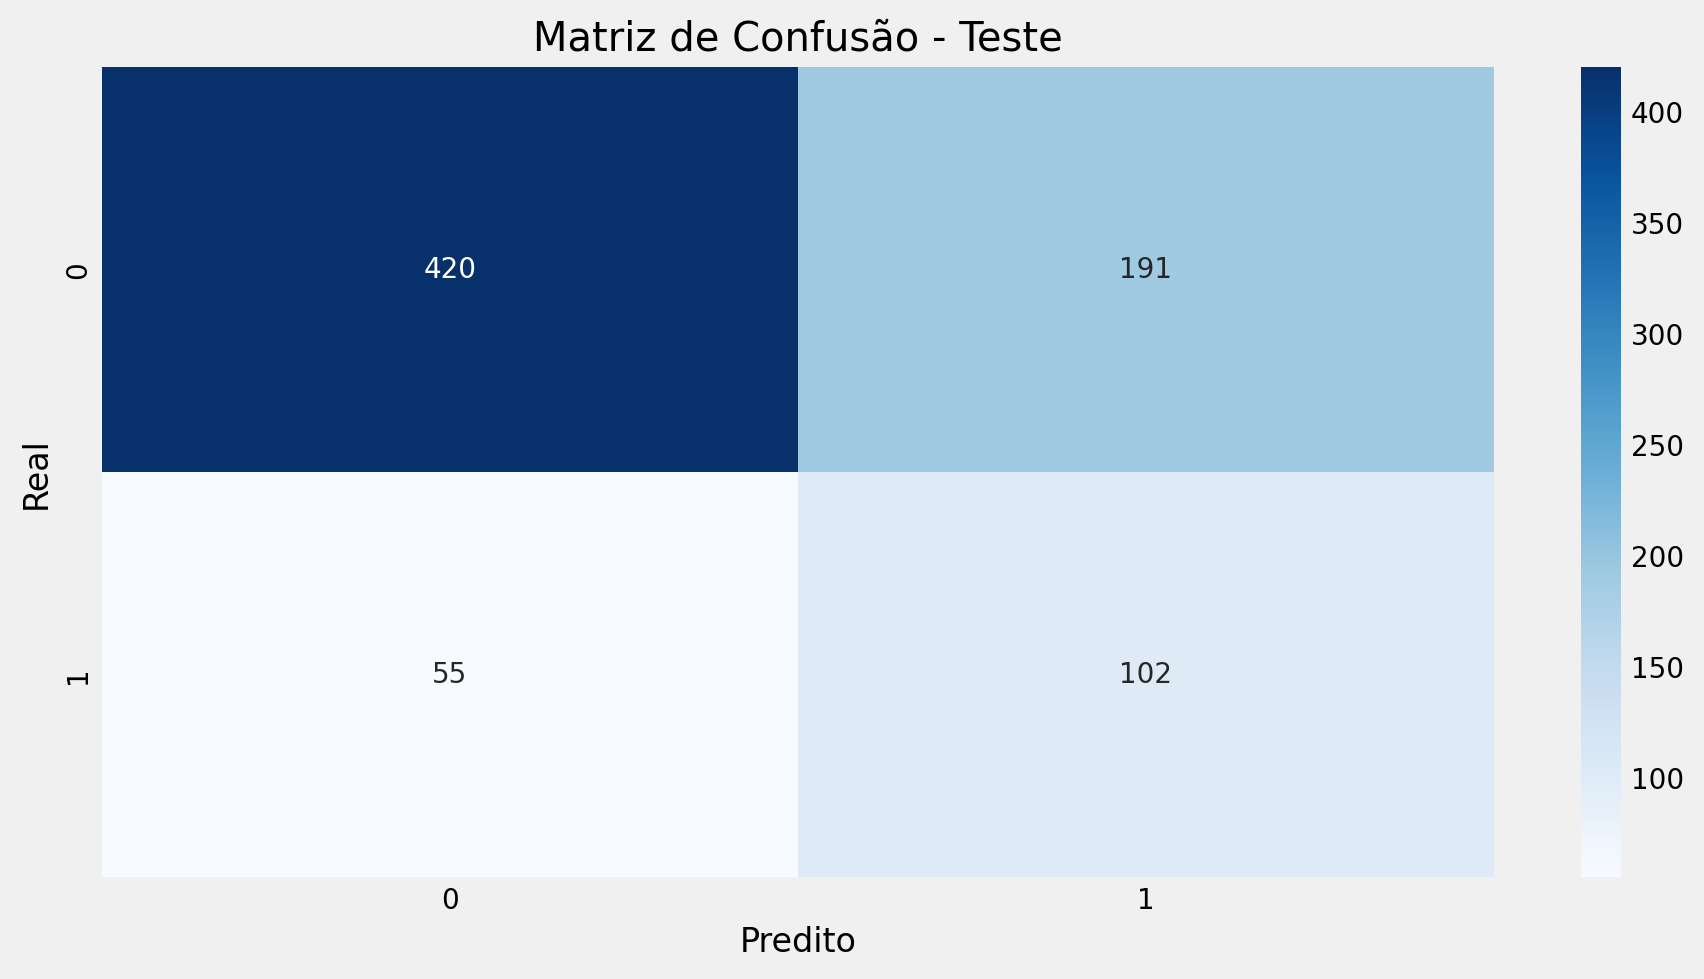

Especificidade - Teste: 0.6874


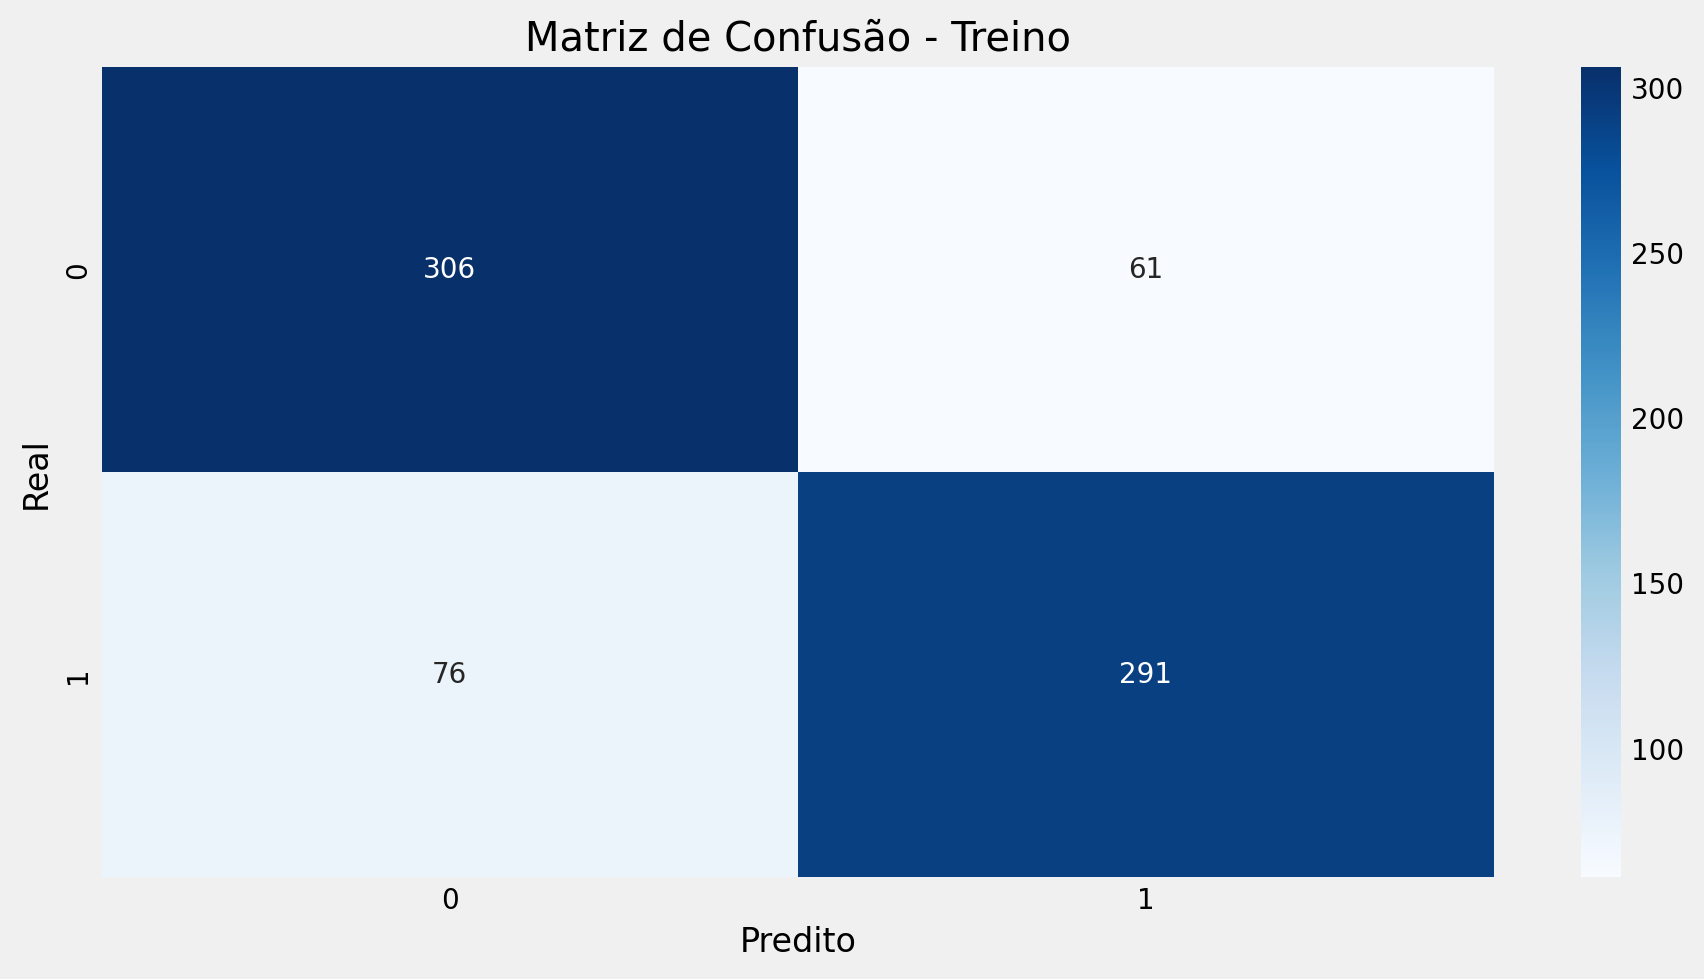

Especificidade - Treino: 0.8338
Catboost Model com Threshold de 0.5 - Treino
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       367
           1       0.83      0.79      0.81       367

    accuracy                           0.81       734
   macro avg       0.81      0.81      0.81       734
weighted avg       0.81      0.81      0.81       734



In [ ]:
# Testes em 18/04/2024 com especificidade
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Aplicando RandomUnderSampler ao conjunto de treinamento
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Definição do modelo CatBoost com hiperparâmetros otimizados
catboost_otimizado = CatBoostClassifier(eval_metric='Logloss', silent=True, random_seed=42, depth=3, iterations=100, learning_rate=0.1, l2_leaf_reg=3, border_count=10)

# Treinamento do modelo CatBoost com os dados balanceados
catboost_otimizado.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de treinamento para avaliação
y_train_pred = catboost_otimizado.predict(X_train_resampled)
y_train_pred_proba = catboost_otimizado.predict_proba(X_train_resampled)[:, 1]
y_train_pred_custom_threshold = (y_train_pred_proba >= 0.5).astype(int)

# Previsões e probabilidades no conjunto de teste
y_pred_catboost = catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:, 1]
y_pred_custom_threshold_catboost = (prob_pos_catboost >= 0.5).astype(int)

# Avaliação do desempenho do modelo no conjunto de teste
print('Catboost Model com Threshold de 0.5 - Teste')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_custom_threshold_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_custom_threshold_catboost, zero_division=0)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_custom_threshold_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))
print(classification_report(y_test, y_pred_custom_threshold_catboost))

# Matriz de Confusão - Teste
conf_matrix_test = confusion_matrix(y_test, y_pred_custom_threshold_catboost)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Teste")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Calculando a especificidade - Teste
tn, fp, fn, tp = conf_matrix_test.ravel()
specificity_test = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Especificidade - Teste: {specificity_test:.4f}")

# Matriz de Confusão - Treinamento
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred_custom_threshold)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Treino")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Calculando a especificidade - Treinamento
tn, fp, fn, tp = conf_matrix_train.ravel()
specificity_train = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Especificidade - Treino: {specificity_train:.4f}")

# Avaliação do desempenho do modelo no conjunto de treinamento
print('Catboost Model com Threshold de 0.5 - Treino')
print(classification_report(y_train_resampled, y_train_pred_custom_threshold))

Catboost Model com Threshold de 0.5 - Teste
Accuracy: 0.8047
Precision: 0.5854
Recall: 0.1529
AUC: 0.7210
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       611
           1       0.59      0.15      0.24       157

    accuracy                           0.80       768
   macro avg       0.70      0.56      0.57       768
weighted avg       0.77      0.80      0.76       768



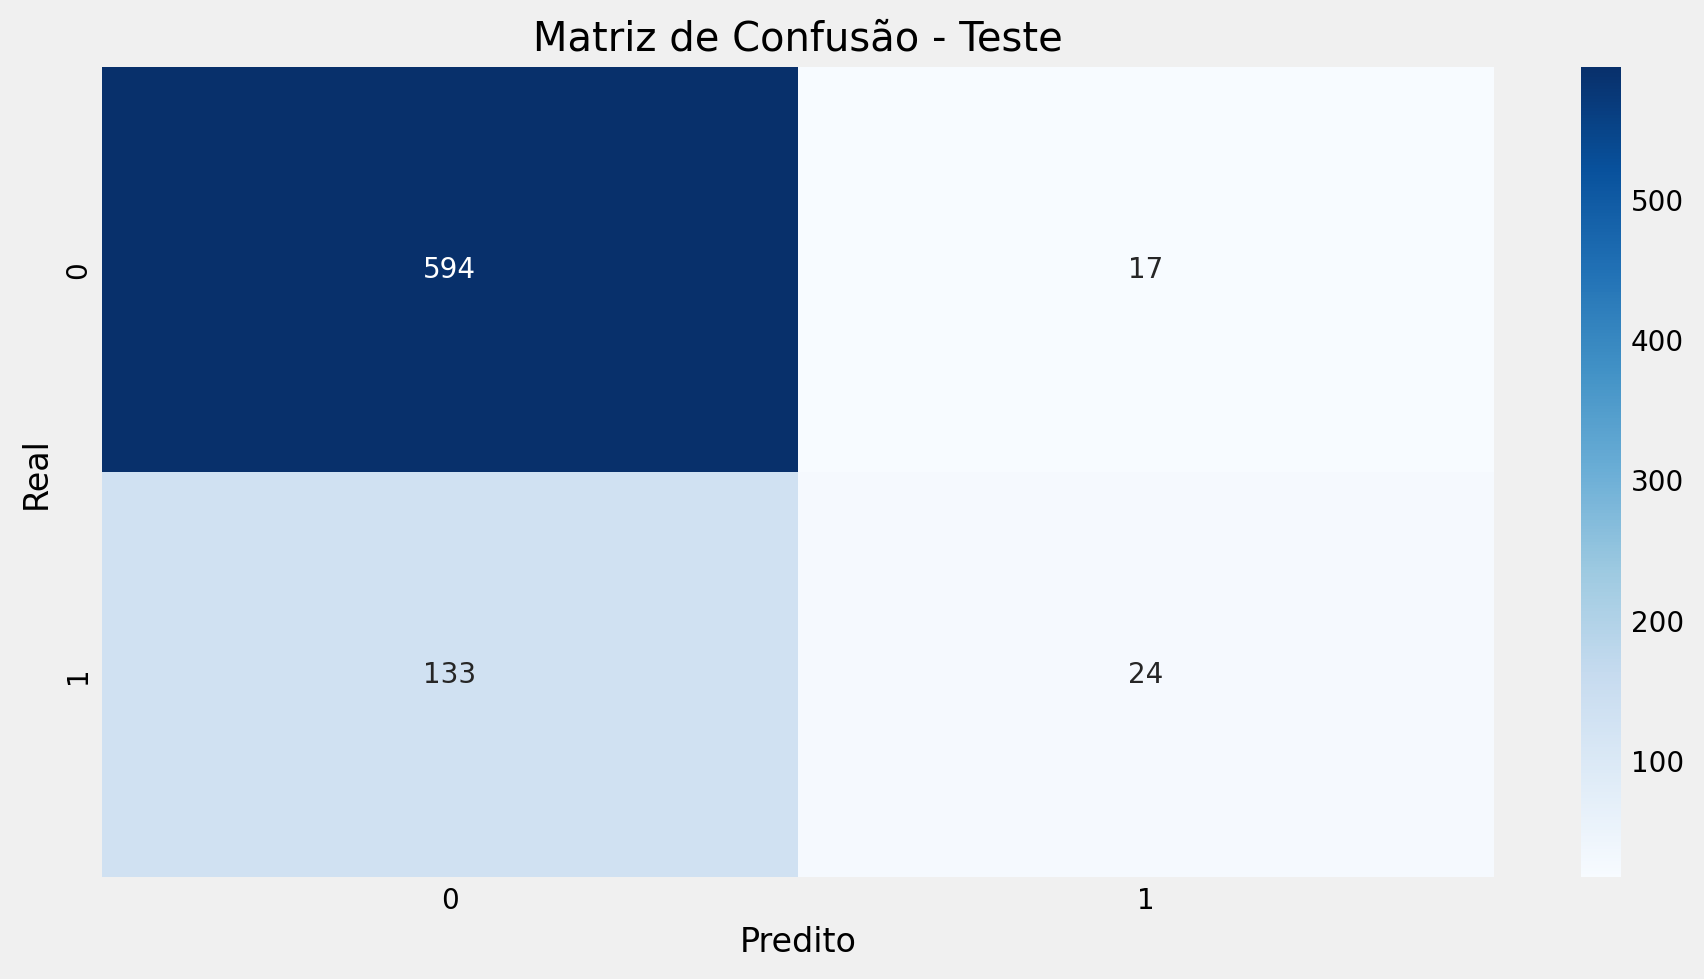

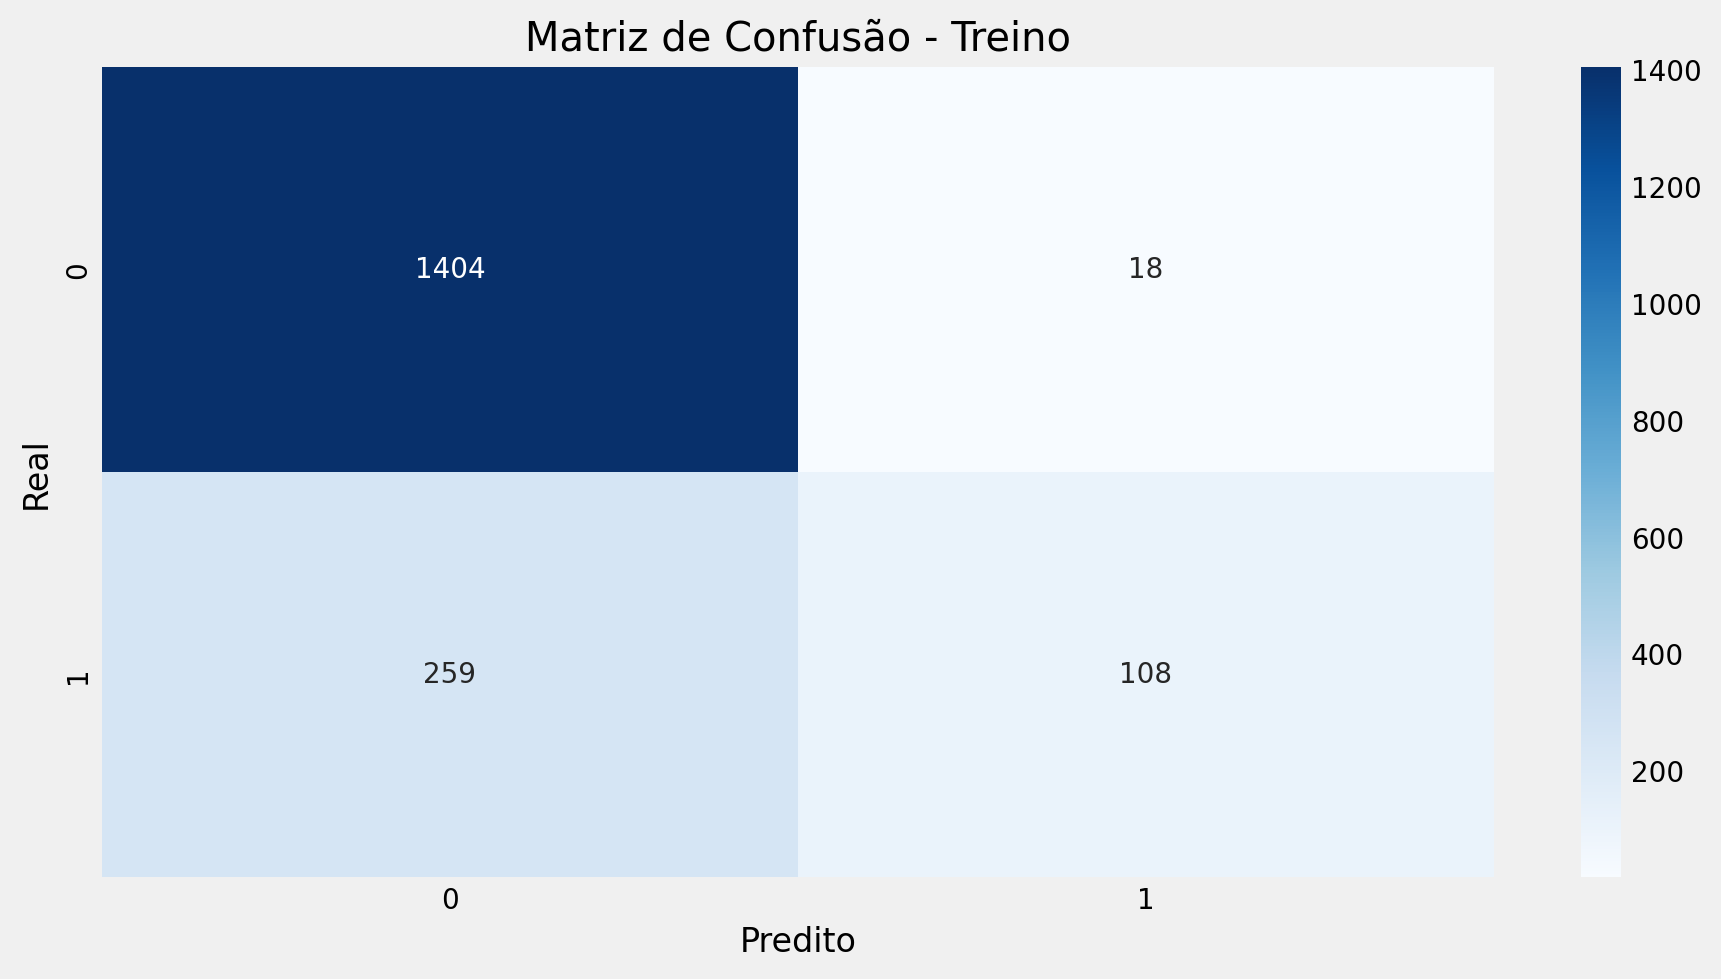

Catboost Model com Threshold de 0.5 - Treino
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1422
           1       0.86      0.29      0.44       367

    accuracy                           0.85      1789
   macro avg       0.85      0.64      0.67      1789
weighted avg       0.85      0.85      0.81      1789



In [ ]:
#Teste Ricardo sem balanceamento
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que X e y são seus dados e rótulos
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Definição do modelo CatBoost com hiperparâmetros otimizados
catboost_otimizado = CatBoostClassifier(eval_metric='Logloss', silent=True, random_seed=42, depth=3, iterations=100, learning_rate=0.1, l2_leaf_reg=3, border_count=10)

# Treinamento do modelo CatBoost com os dados originais de treinamento
catboost_otimizado.fit(X_train, y_train)

# Previsões no conjunto de treinamento para avaliação
y_train_pred = catboost_otimizado.predict(X_train)
y_train_pred_proba = catboost_otimizado.predict_proba(X_train)[:, 1]
y_train_pred_custom_threshold = (y_train_pred_proba >= 0.5).astype(int)

# Previsões e probabilidades no conjunto de teste
y_pred_catboost = catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:, 1]
y_pred_custom_threshold_catboost = (prob_pos_catboost >= 0.5).astype(int)

# Avaliação do desempenho do modelo no conjunto de teste
print('Catboost Model com Threshold de 0.5 - Teste')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_custom_threshold_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_custom_threshold_catboost, zero_division=0)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_custom_threshold_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))
print(classification_report(y_test, y_pred_custom_threshold_catboost))

# Matriz de Confusão - Teste
conf_matrix_test = confusion_matrix(y_test, y_pred_custom_threshold_catboost)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Teste")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Avaliação do desempenho do modelo no conjunto de treinamento usando os dados originais
conf_matrix_train = confusion_matrix(y_train, y_train_pred_custom_threshold)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Treino")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

print('Catboost Model com Threshold de 0.5 - Treino')
print(classification_report(y_train, y_train_pred_custom_threshold))

Catboost Model com Class Weights - Teste
Accuracy: 0.9008
Precision: 0.6341
Recall: 0.0893
AUC: 0.7730
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      2533
           1       0.63      0.09      0.16       291

    accuracy                           0.90      2824
   macro avg       0.77      0.54      0.55      2824
weighted avg       0.88      0.90      0.87      2824



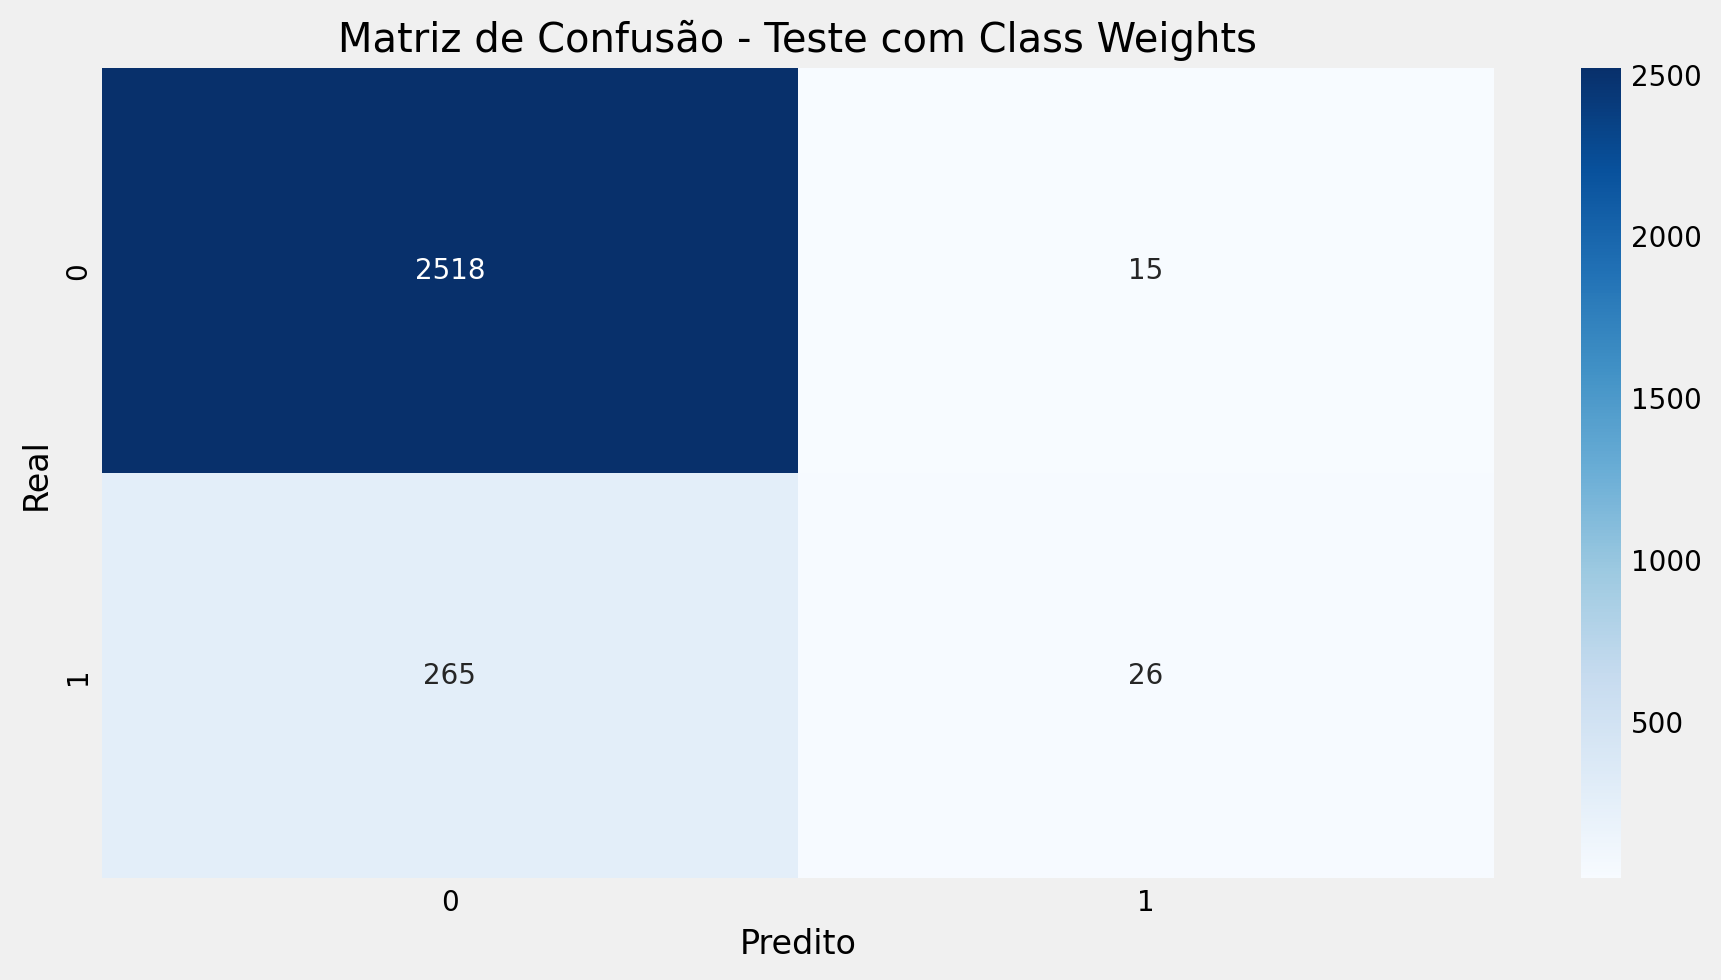

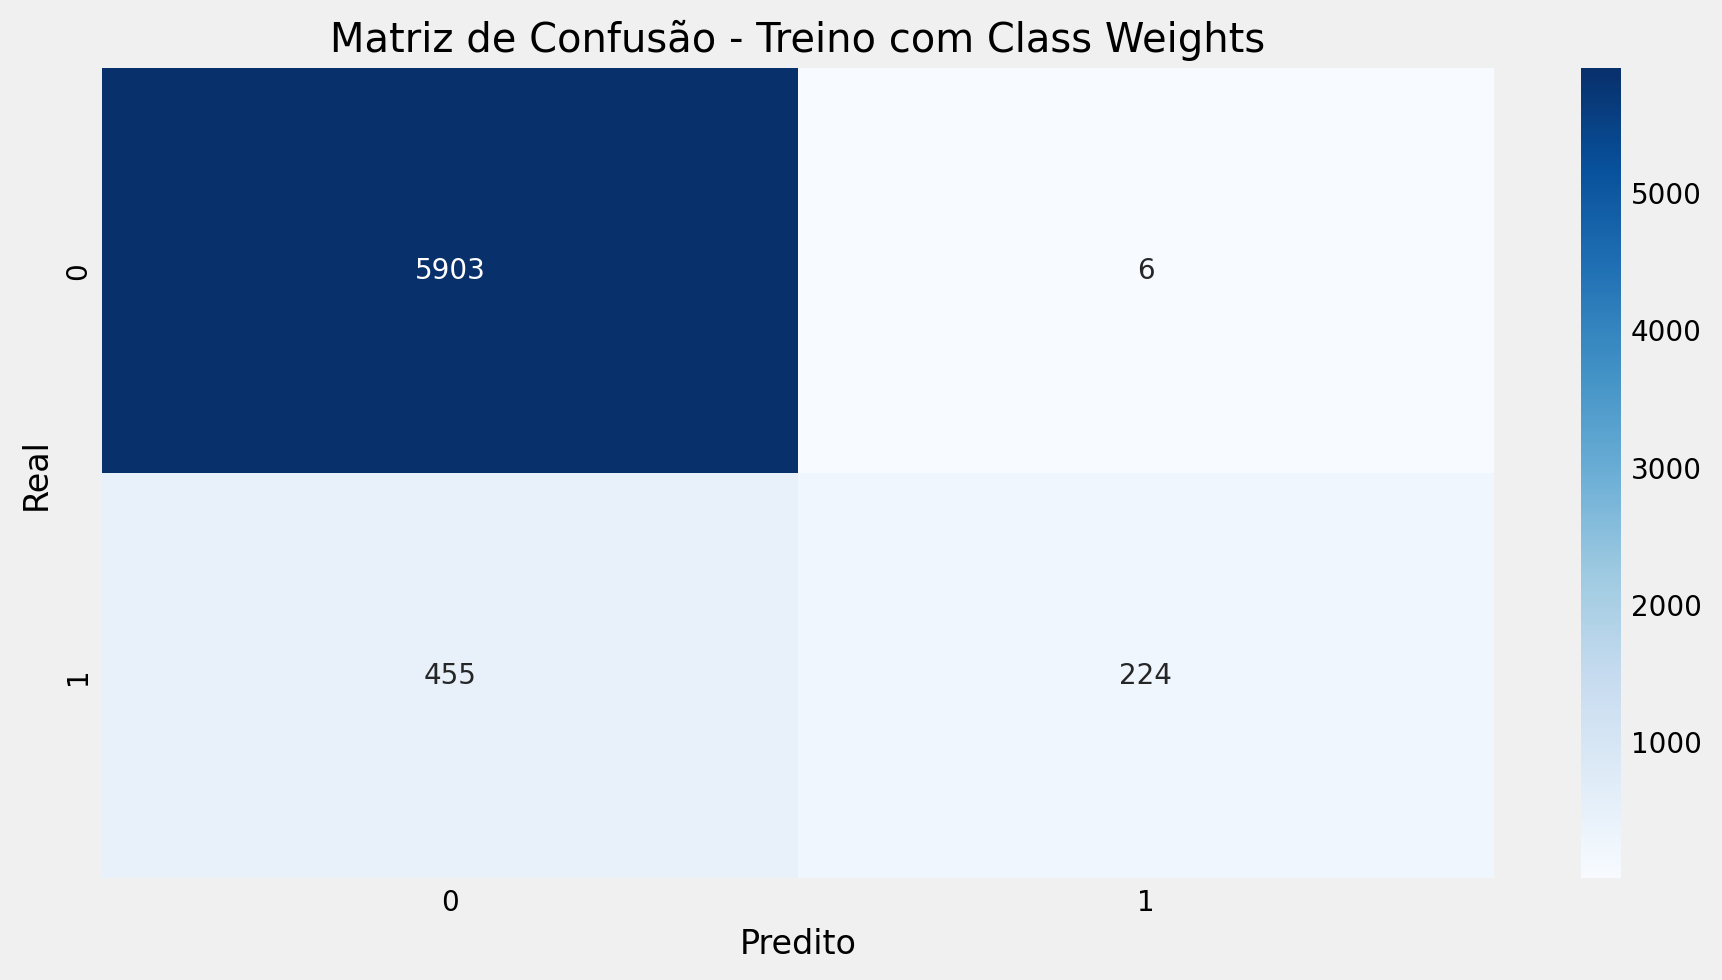

Catboost Model com Class Weights - Treino
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5909
           1       0.97      0.33      0.49       679

    accuracy                           0.93      6588
   macro avg       0.95      0.66      0.73      6588
weighted avg       0.93      0.93      0.91      6588



In [ ]:
#Teste Ricardo - Com classweight
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Supondo que X e y são seus dados e rótulos
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Calcula as proporções inversas das classes para usar como pesos
unique_classes = np.unique(y_train)
class_weights = {class_label: 1. / np.sum(y_train == class_label) for class_label in unique_classes}
# Transforma em lista de pesos conforme a ordem das classes
class_weights_list = [class_weights[class_label] for class_label in unique_classes]

# Definição do modelo CatBoost com class_weights
catboost_otimizado = CatBoostClassifier(
    eval_metric='Logloss',
    silent=True,
    random_seed=42,
    depth=8,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=100,
    border_count=200,
    class_weights=class_weights_list
)

# Treinamento do modelo CatBoost com os dados de treinamento e pesos de classe
catboost_otimizado.fit(X_train, y_train)

# As etapas de previsão e avaliação permanecem as mesmas
...

# Avaliação do desempenho do modelo no conjunto de teste
print('Catboost Model com Class Weights - Teste')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_custom_threshold_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_custom_threshold_catboost, zero_division=0)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_custom_threshold_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))
print(classification_report(y_test, y_pred_custom_threshold_catboost))

# Matriz de Confusão - Teste
conf_matrix_test = confusion_matrix(y_test, y_pred_custom_threshold_catboost)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Teste com Class Weights")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Avaliação do desempenho do modelo no conjunto de treinamento usando os dados originais
conf_matrix_train = confusion_matrix(y_train, y_train_pred_custom_threshold)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Treino com Class Weights")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

print('Catboost Model com Class Weights - Treino')
print(classification_report(y_train, y_train_pred_custom_threshold))

Catboost Model com Threshold de 0.5 - Teste
Accuracy: 0.7472
Precision: 0.2285
Recall: 0.6117
AUC: 0.7629
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2533
           1       0.23      0.61      0.33       291

    accuracy                           0.75      2824
   macro avg       0.59      0.69      0.59      2824
weighted avg       0.87      0.75      0.79      2824



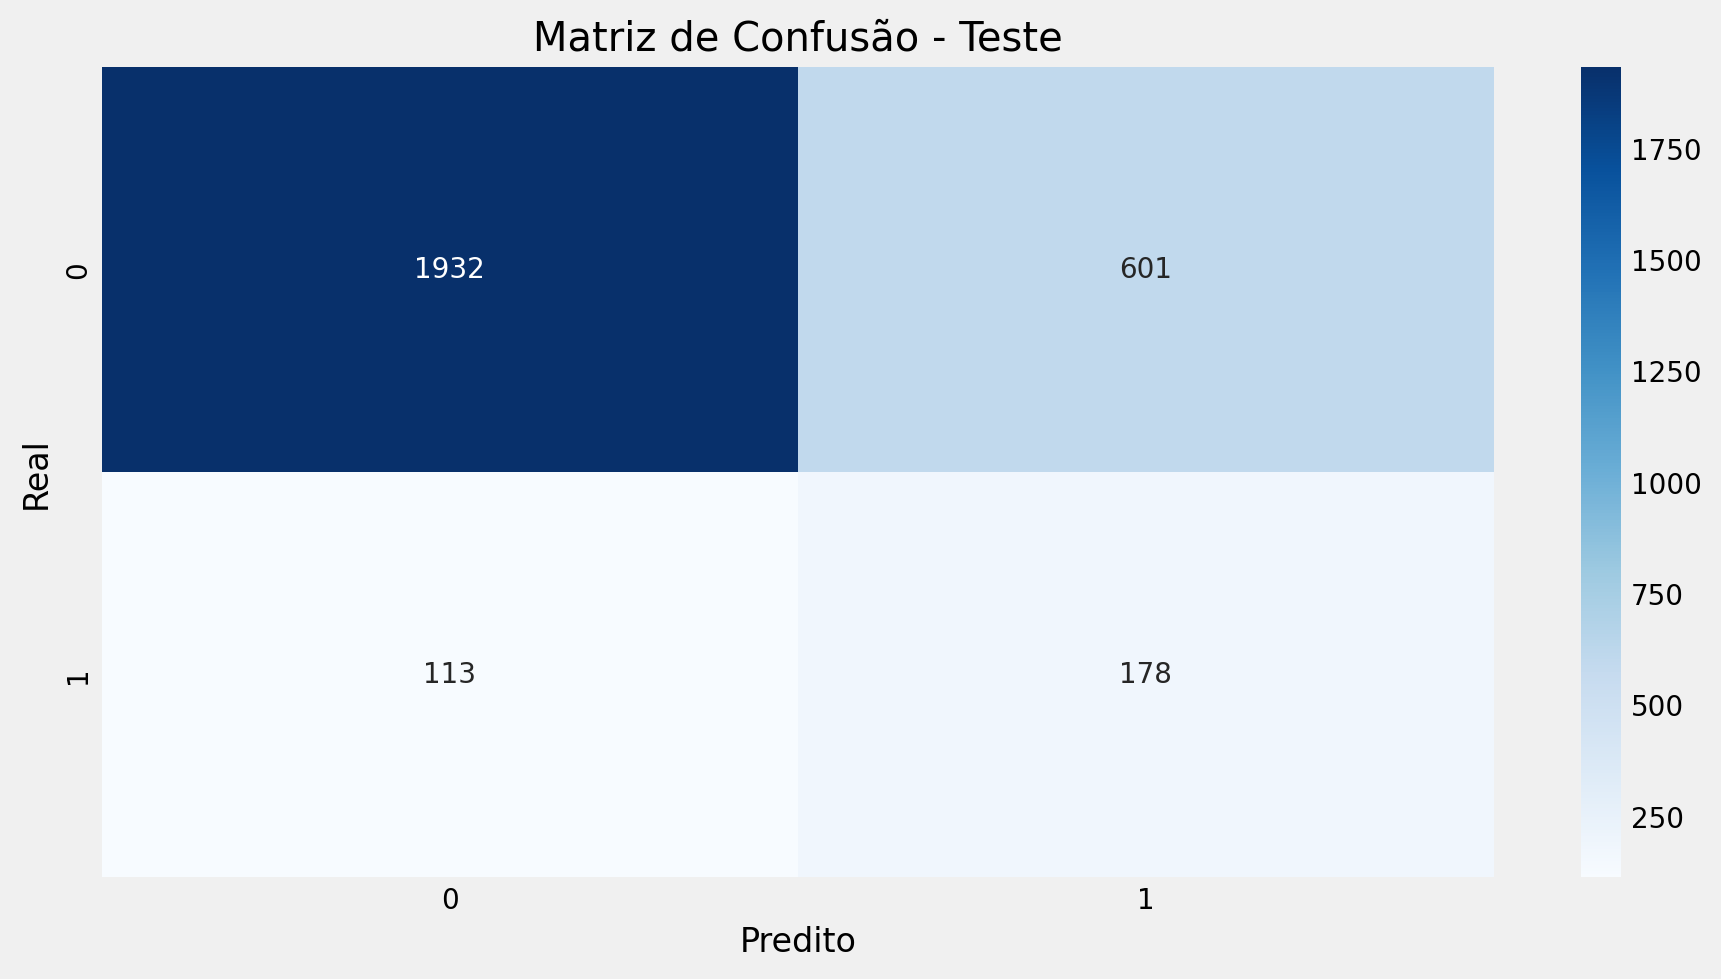

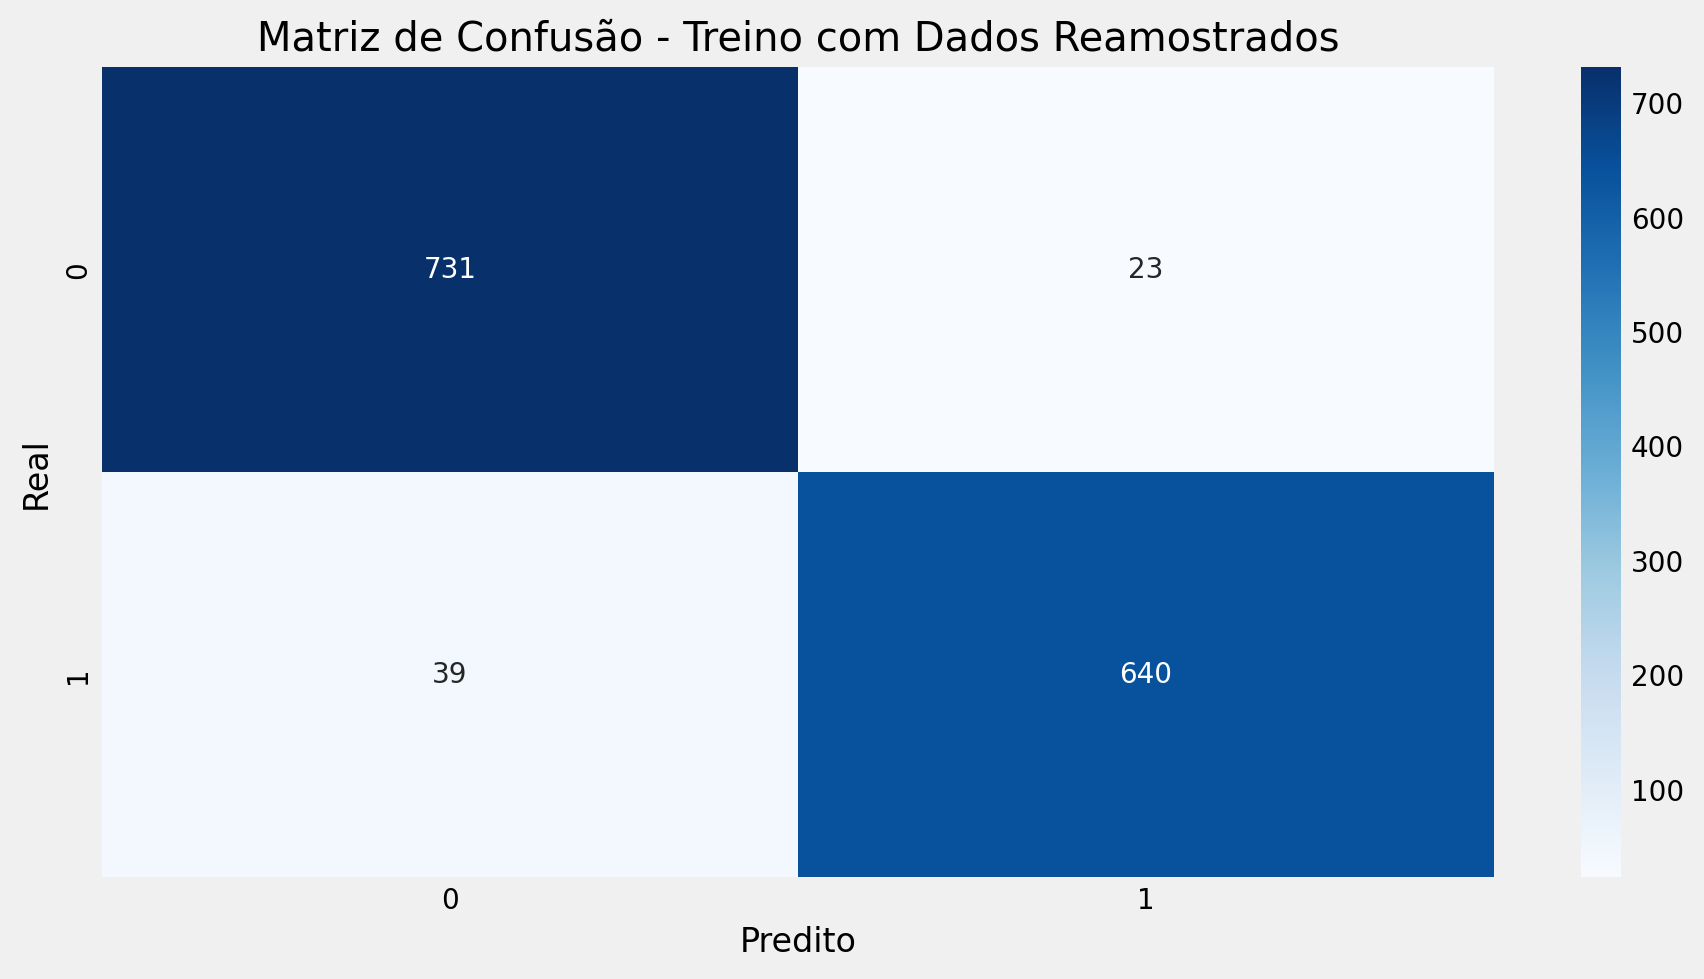

Catboost Model com Dados Reamostrados - Treino
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       754
           1       0.97      0.94      0.95       679

    accuracy                           0.96      1433
   macro avg       0.96      0.96      0.96      1433
weighted avg       0.96      0.96      0.96      1433



In [ ]:
#Testando com Random Under Sampling e balanceamento parcial
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Suponha que você tenha seus dados X e rótulos y definidos aqui
# X, y = load_your_data_function()

# Dividindo os dados em conjuntos de treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Configurando o Random Under Sampler
# Ajuste o 'sampling_strategy' conforme necessário para controlar o nível de desbalanceamento
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

# Aplicando o Random Under Sampling nos dados de treinamento
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Definindo o modelo CatBoost com os parâmetros desejados
catboost_otimizado = CatBoostClassifier(
    eval_metric='Logloss',
    silent=True,
    random_seed=42,
    depth=8,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=100,
    border_count=200
)

# Treinando o modelo com os dados reamostrados
catboost_otimizado.fit(X_train_res, y_train_res)

# Realizando previsões no conjunto de treinamento para avaliação
y_train_pred = catboost_otimizado.predict(X_train_res)
y_train_pred_proba = catboost_otimizado.predict_proba(X_train_res)[:, 1]
y_train_pred_custom_threshold = (y_train_pred_proba >= 0.5).astype(int)

# Realizando previsões no conjunto de teste
y_pred_catboost = catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:, 1]
y_pred_custom_threshold_catboost = (prob_pos_catboost >= 0.5).astype(int)

# Avaliando o desempenho no conjunto de teste
print('Catboost Model com Threshold de 0.5 - Teste')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_custom_threshold_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_custom_threshold_catboost, zero_division=0)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_custom_threshold_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))
print(classification_report(y_test, y_pred_custom_threshold_catboost))

# Matriz de Confusão - Teste
conf_matrix_test = confusion_matrix(y_test, y_pred_custom_threshold_catboost)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Teste")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Avaliando o desempenho no conjunto de treinamento com os dados reamostrados
conf_matrix_train = confusion_matrix(y_train_res, y_train_pred_custom_threshold)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Treino com Dados Reamostrados")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

print('Catboost Model com Dados Reamostrados - Treino')
print(classification_report(y_train_res, y_train_pred_custom_threshold))

In [ ]:
# Comparando os resultados dos algoritmos

In [ ]:
# criando uma tabela com as métricas
col_names = ["Modelo", "Accuracy", "Precision", "Recall", "AUC(ROC)"] # definindo o cabeçalho

# definindo os valores
data = [["Random Forest", accuracy_score(y_test, y_pred_rf),precision_score(y_test, y_pred_rf),recall_score(y_test, y_pred_rf),roc_auc_score(y_test, prob_pos_rf)],
        ["XGBoost", accuracy_score(y_test, y_pred_xgboost),precision_score(y_test, y_pred_xgboost),recall_score(y_test, y_pred_xgboost),roc_auc_score(y_test, prob_pos_xgboost)],
        ["LightGBM", accuracy_score(y_test, y_pred_lgbm),precision_score(y_test, y_pred_lgbm),recall_score(y_test, y_pred_lgbm),roc_auc_score(y_test, prob_pos_lgbm)],
        ["Catboost", accuracy_score(y_test, y_pred_catboost),precision_score(y_test, y_pred_catboost),recall_score(y_test, y_pred_catboost),roc_auc_score(y_test, prob_pos_catboost)]]


NameError: name 'y_pred_rf' is not defined

In [ ]:
pd.set_option('display.float_format', lambda x: '%2f' % x) # tabela com três casas decimais

print('Resultados para conjunto de teste.')
df_results = pd.DataFrame(data, columns = col_names) # transformando os resultados do teste em um data.frame

# função para destacarmos os maiores valores em cada uma das métricas
def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])] # estamos declarando que quando o tipo de dado for objeto, não aplicaremos o highlight
    else:
        is_max = s == s.max()
    return ['background: yellow' if cell else '' for cell in is_max]

df_results.style.apply(highlight_max)


Resultados para conjunto de teste.


,Modelo,Accuracy,Precision,Recall,AUC(ROC)
0,Random Forest,0.763597,0.663359,0.322578,0.772750
1,XGBoost,0.764341,0.654201,0.342638,0.776806
2,LightGBM,0.761416,0.629816,0.366578,0.771175
3,Catboost,0.764714,0.648644,0.355318,0.777029


**8. Seleção de variáveis com BORUTA**


In [ ]:
!pip install boruta # instalando o boruta. Ideal é que para a versão final do código, as instalações e importações sejam reunidas no início

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 3.4 MB/s eta 0:00:00


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# criando estimador para o Boruta. Por padrão, utilizamos o RandomForestClassifier, porém é possível alterar para outros algoritmos, como o lgbm
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 5
)

boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 100 # número de iterações. quanto maior, mais demorado
)

# parametrizando para o conjunto de treino
boruta.fit(np.array(X_train), np.array(y_train)) # aplicamos o boruta no treino

# resultados
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']
features in the blue area: []


In [ ]:
# Modelo com Boruta - Selecionado as variáveis preditoras
X_train_boruta = X_train[['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

X_test_boruta = X_test[['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

print('Shape sem boruta', X_train.shape, X_test.shape)
print('Shape com boruta', X_train_boruta.shape, X_test_boruta.shape)

# verificamos que o boruta removeu somente uma variável preditora

Shape sem boruta (87734, 12) (37601, 12)
Shape com boruta (87734, 11) (37601, 11)


**9. Catboost com BORUTA**

Utilizamos o Catboost, pois foi o algoritmo com melhor desempenho entre os quatro testados

In [1]:
catboost_otimizado_boruta = CatBoostClassifier(eval_metric='Logloss', silent = True, random_seed=42,
                                        learning_rate= 0.01,
                                        l2_leaf_reg= 3,
                                        iterations= 1000,
                                        depth= 5,
                                        border_count= 200)
catboost_otimizado_boruta.fit(X_train_boruta, y_train)

NameError: name 'CatBoostClassifier' is not defined

In [ ]:
# catboost

y_pred_catboost_boruta = catboost_otimizado_boruta.predict(X_test_boruta)
prob_pos_catboost_boruta = catboost_otimizado_boruta.predict_proba(X_test_boruta)[:,1]

print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost_boruta)))

print(classification_report(y_test, y_pred_xgboost))

XGBoost Model
Accuracy: 0.7651
Precision: 0.6500
Recall: 0.3558
AUC: 0.7769
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     27033
           1       0.65      0.34      0.45     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601



**Comparando os resultados do teste c/ e s/ BORUTA para o catboost**

In [ ]:
print("###### CATBOOST SEM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

print(classification_report(y_test, y_pred_catboost))

print("\n", "###### CATBOOST COM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost_boruta)))

print(classification_report(y_test, y_pred_catboost))

###### CATBOOST SEM BORUTA #####
Accuracy: 0.7647
Precision: 0.6486
Recall: 0.3553
AUC: 0.7770
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     27033
           1       0.65      0.36      0.46     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601


 ###### CATBOOST COM BORUTA #####
Accuracy: 0.7651
Precision: 0.6500
Recall: 0.3558
AUC: 0.7769
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     27033
           1       0.65      0.36      0.46     10568

    accuracy                           0.76     37601
   macro avg       0.72      0.64      0.65     37601
weighted avg       0.75      0.76      0.74     37601



**Obtendo as predições e os riscos para os pacientes do teste**

In [ ]:
X_test # verificando o conjuto X de teste

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White
0,-0.765511,1.387139,-1.091504,-0.891419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,-0.336487,-0.206144,-0.348660,-1.397151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,1.915894,1.614750,0.124058,-0.986243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,-0.658255,0.021468,-0.990207,-0.701769,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4,1.701382,0.249080,-0.449957,0.688994,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
37596,-0.336487,2.297585,-0.956441,1.163118,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
37597,-1.194536,2.980421,0.090292,-0.638553,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
37598,2.130407,-1.116590,0.866901,1.257942,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
37599,-0.336487,0.249080,-0.078536,1.795282,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
desfecho = pd.DataFrame({'desfecho':y_test}) # verificando o conjunto y de teste
desfecho.head()

,desfecho
0,0
1,1
2,0
3,1
4,1


In [ ]:
desfecho_predito = pd.DataFrame({'desfecho_predito':y_pred_catboost_boruta})
desfecho_predito.head()

,desfecho_predito
0,0
1,0
2,0
3,0
4,1


In [ ]:
prob_predita = pd.DataFrame({'prob_predita':prob_pos_catboost_boruta})
prob_predita.head()

,prob_predita
0,0.063465
1,0.052826
2,0.174498
3,0.217745
4,0.651217


In [ ]:
pd.concat([X_test, desfecho, desfecho_predito, prob_predita], axis=1) # juntado o X_test, o desfecho, a predição e a probabilidade predita

,numAge,bmi,tchol,sbp,htn,smoking,t2d,gender,race_AmInd,race_Asian/PI,race_Black/AfAm,race_White,desfecho,desfecho_predito,prob_predita
0,-0.765511,1.387139,-1.091504,-0.891419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0.063465
1,-0.336487,-0.206144,-0.348660,-1.397151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.052826
2,1.915894,1.614750,0.124058,-0.986243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,0,0.174498
3,-0.658255,0.021468,-0.990207,-0.701769,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.217745
4,1.701382,0.249080,-0.449957,0.688994,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,1,0.651217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37596,-0.336487,2.297585,-0.956441,1.163118,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,1,0.547597
37597,-1.194536,2.980421,0.090292,-0.638553,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.231499
37598,2.130407,-1.116590,0.866901,1.257942,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0,1,0.545894
37599,-0.336487,0.249080,-0.078536,1.795282,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,0.488874


**10. Valores de Shapley**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 18.6 MB/s eta 0:00:00


In [ ]:
import shap

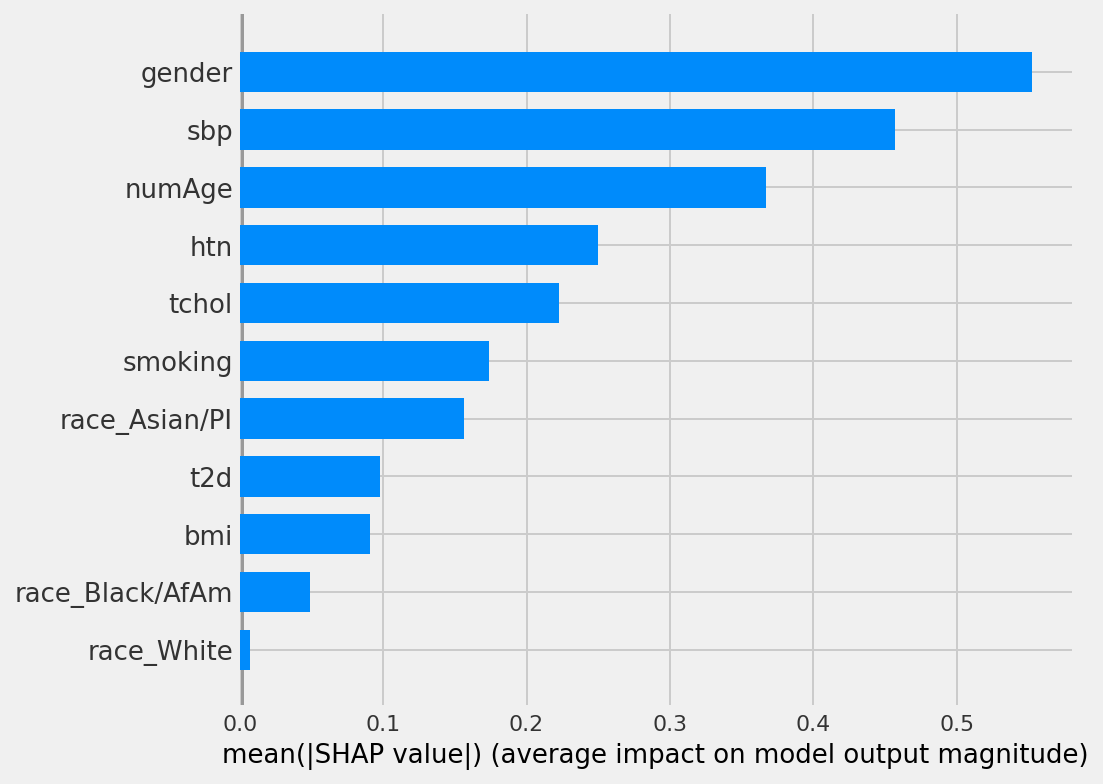

In [ ]:
# resultados no teste
shap_values_test = shap.TreeExplainer(catboost_otimizado_boruta).shap_values(X_test_boruta)
shap.summary_plot(shap_values_test, X_test_boruta, plot_type="bar")

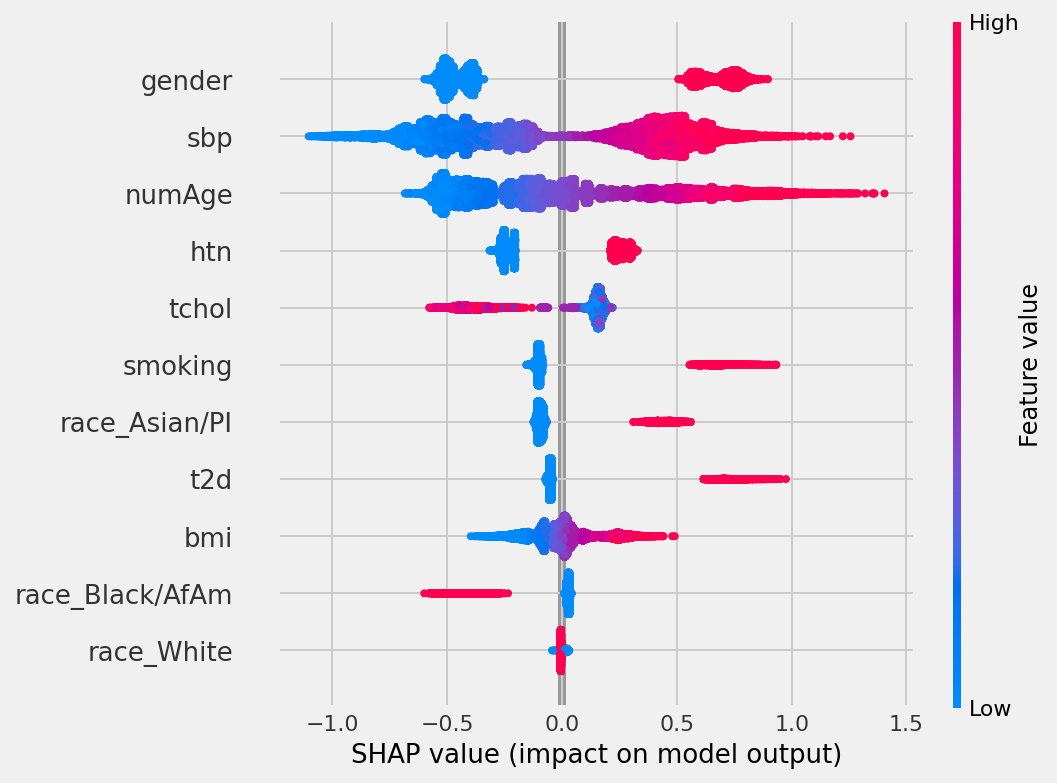

In [ ]:
shap.summary_plot(shap_values_test, X_test_boruta)

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(catboost_otimizado_boruta)
shap_values = explainer.shap_values(X_test_boruta)

i = 0
# Inserindo os dados do paciente
print('Desfecho do paciente:', y_test[i])
print('Predição:', y_pred_xgboost_boruta[i])

# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_boruta.iloc[i,:])

Desfecho do paciente: 0
Predição: 0


**11. Salvando e carregando o modelo**

Finalizamos a análise e salvaremos o algoritmo para alguma aplicação futura

In [ ]:
import joblib
import os

In [ ]:
def save_model(model, path):
    """Função para salvar o modelo localmente.
    Args:
        model: Modelo para salvar
        path (str): caminho para salvar o modelo
    """
    if os.path.dirname(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        joblib.dump(model, f)

In [ ]:
# salvando o modelo catboost otimizado com seleção de variáveis feita pelo boruta
save_model(catboost_otimizado_boruta, 'models/catboost_otimizado_boruta.pkl')

**Carregando um modelo desenvolvido previamente**

In [ ]:
def read_model(path):
    """Função para ler um modelo salvo
    Args:
        path (str): caminho do modelo salvo
    Returns:
        file: modelo carregado
    """
    with open(path, "rb") as f:
        file = joblib.load(f)

    return file

In [ ]:
# alterar caminho e nome do modelo conforme necessidades
modelo_carregado = read_model('models/catboost_otimizado_boruta.pkl')

In [ ]:
# obtendo os hiperparâmetros do modelo
modelo_carregado.get_params()

{'iterations': 1000,
 'learning_rate': 0.01,
 'depth': 5,
 'l2_leaf_reg': 3,
 'border_count': 200,
 'random_seed': 42,
 'silent': True,
 'eval_metric': 'Logloss'}

In [ ]:
# revalidando os resultados de teste
# em uma aplicação real, após as etapas de pré-processamento nos dados novos,
# faríamos as predições nos novos indivíduos após o carregamento de um modelo pré-treinado
resultado = modelo_carregado.score(X_test_boruta, y_test) # padrão da função é a acurácia. Aqui utilizamos somente para demonstrar e comparar os valores como exemplo
resultado

0.7650860349458791